In [69]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)}) #may remove it later

#may remove it later
# import plotly
# # connected=True means it will download the latest version of plotly javascript library.
# plotly.offline.init_notebook_mode(connected=True)
# import plotly.graph_objs as go

# import plotly.figure_factory as ff
# import cufflinks as cf
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

In [70]:
np.random.seed(14)

df = pd.read_csv('../android-app-market-analysis/data/googleplaystore.csv')

df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9382,ZOMBIE RIPPER,GAME,3.7,16073,94M,"500,000+",Free,0,Mature 17+,Action,"November 14, 2017",1.4,4.0 and up
2737,Extreme Coupon Finder,SHOPPING,4.1,11798,Varies with device,"1,000,000+",Free,0,Everyone,Shopping,"May 10, 2018",Varies with device,Varies with device
7351,tutti.ch - Free Classifieds,SHOPPING,4.4,9950,15M,"500,000+",Free,0,Everyone,Shopping,"July 18, 2018",3.7.1,4.1 and up
8634,File Viewer for Android,TOOLS,4.1,7063,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"January 25, 2018",2.3.2,5.0 and up
4383,Hands 'n Guns Simulator,FAMILY,3.9,19727,76M,"1,000,000+",Free,0,Teen,Simulation,"July 3, 2018",32,4.1 and up


In [71]:
print('Number of apps in the dataset : ' , len(df), '\n')
df.drop_duplicates(subset='App', inplace=True)
print('Number of apps in the dataset after removing duplicates: ' , len(df),'\n')

# get the number of missing data points per column
print("Numer of missing values per column:")
missing_values_count = df.isnull().sum()
print(missing_values_count)

Number of apps in the dataset :  10841 

Number of apps in the dataset after removing duplicates:  9660 

Numer of missing values per column:
App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


In [72]:
# How many total missing values do we have?
total_cells = df.size
total_missing = missing_values_count.sum()

# percent of data that is missing
percentage_missign_values = (total_missing/total_cells) * 100
print(percentage_missign_values, '%')

1.175346392737697 %


In [73]:
for column in df.columns:
    print(df[column].value_counts())

Auto Dslr Photo Effect : Auto Focus Effect            1
TwitCasting Live                                      1
Fresh EBT - Food Stamp Balance                        1
FO AIRBUS Nantes                                      1
Best Western To Go                                    1
mon guide au bank populaire -infos et instructions    1
SweetRing - Meet, Match, Date                         1
Bixby Button Remapper - bxActions Pro / Coffee        1
BI-LO                                                 1
Hospital ER Emergency Heart Surgery: Doctor Games     1
Chick-fil-A                                           1
DreamWorks Friends                                    1
                                                     ..
Moto Photo Editor                                     1
Flashlight Ultimate                                   1
The wall                                              1
Axxess AX-DSP                                         1
K-Chiing VPN (Free)                             

In [74]:
# Column: Installs -> Remove Wrong Values ('Free'), remove + and , then typecast it to int
                
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: float(x))
print(type(df['Installs'][0]))

<class 'numpy.float64'>


In [76]:
# Column: Size -> Remove 'M', Replace 'k' and divide by 1000 (1MB = 1000 KB)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))

# Column: Price -> Remove '$' sign
df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

print(df.dtypes)

App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


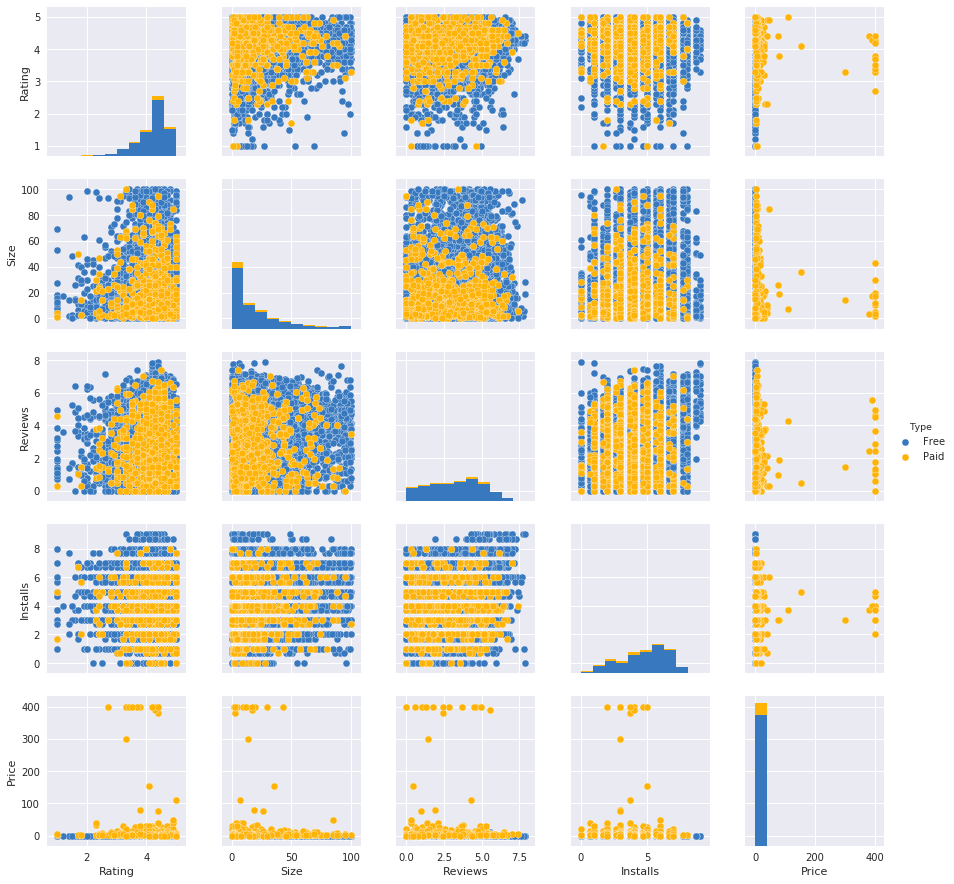

In [86]:
rating = df['Rating'].dropna()
size = df['Size'].dropna()
installs = np.log10(df['Installs'][df.Installs!=0].dropna()) #eliminate zeros for computing log
reviews = np.log10(df['Reviews'][df.Reviews!=0].dropna()) #eliminate zeros for computing log
app_type = df['Type'].dropna()
price = df['Price']

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
p = sns.pairplot(pd.DataFrame(list(zip(rating, size, reviews, installs, app_type, price)), 
                        columns=['Rating','Size', 'Reviews', 'Installs', 'Type', 'Price']), hue='Type', palette=sns.xkcd_palette(colors))